<a href="https://colab.research.google.com/github/LukeFic/AE-353/blob/main/370Project1Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

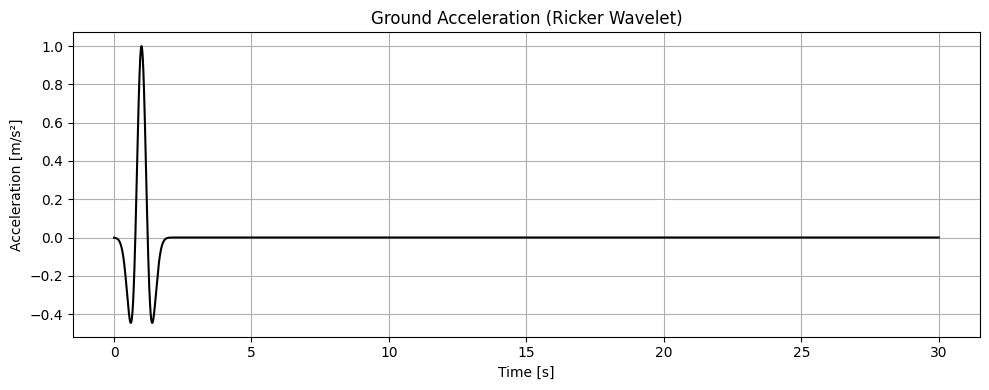

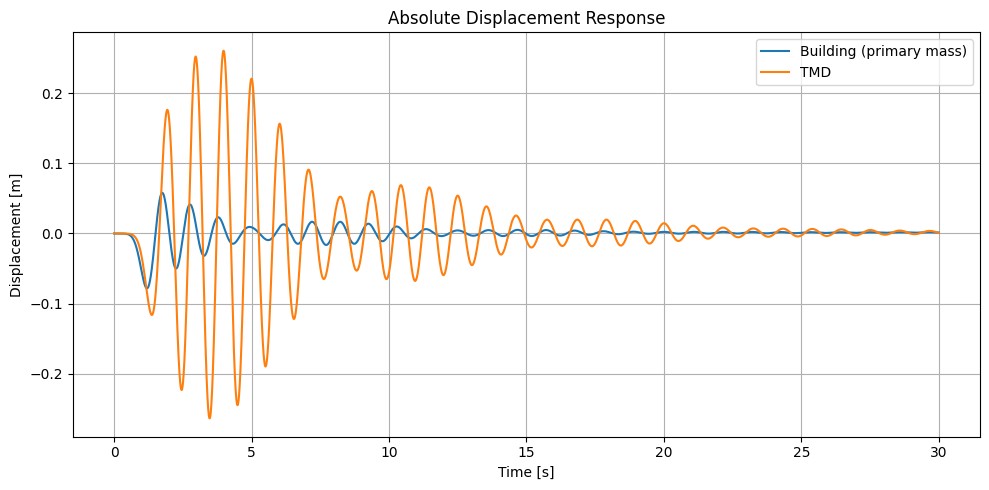

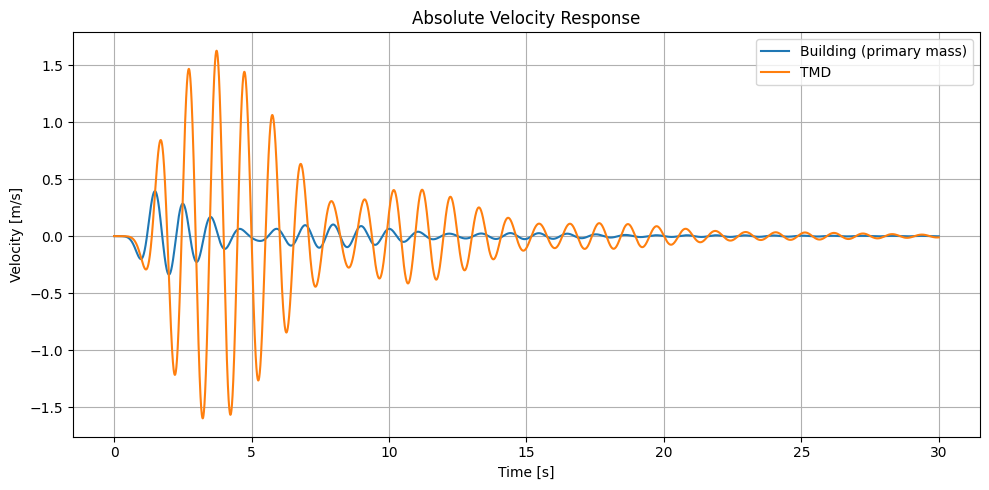

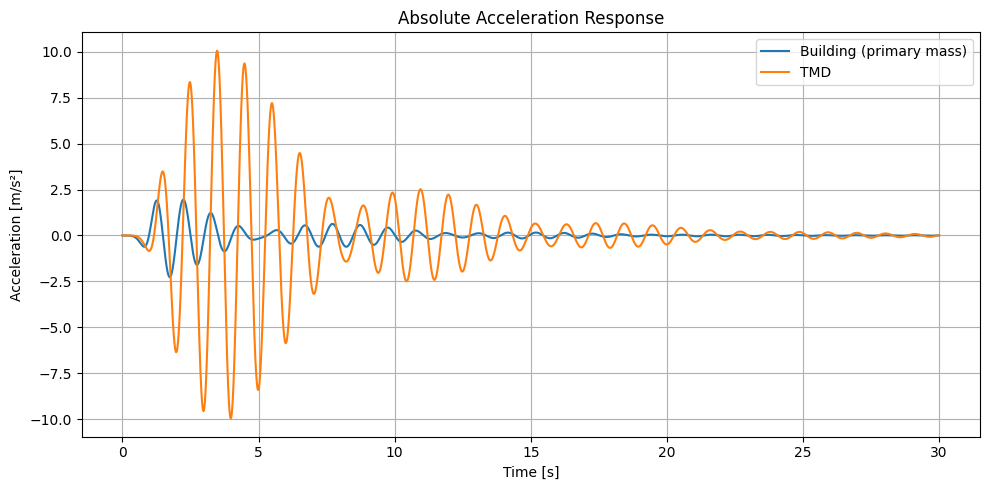

Peak Displacement (Building): 0.0784 m
Peak Displacement (TMD):      0.2640 m
Peak Velocity (Building):     0.3942 m/s
Peak Velocity (TMD):          1.6274 m/s
Peak Accel (Building):        2.2686 m/s²
Peak Accel (TMD):             10.0607 m/s²


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#variables
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building
TMD_ratio = .02 # Ratio of TMD mass to building mass

m2 = m1*TMD_ratio # Mass TMD [kg]
f2 = 1.0        # Natural frequency of TMD (tuned to f1)
zeta2 = 0.05    # Damping ratio of TMD

f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

# 2. Equation of Motions
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

k1 = m1 * omega1**2
k2 = m2 * omega2**2
c1 = 2 * zeta1 * m1 * omega1
c2 = 2 * zeta2 * m2 * omega2

M = np.array([[m1, 0],
              [0,  m2]])
C = np.array([[c1 + c2, -c2],
              [-c2,      c2]])
K = np.array([[k1 + k2, -k2],
              [-k2,      k2]])


# 3. Earthquake (Ricker wavelet) #commonly used model for earthquake shock
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2 * a**2) * np.exp(-a**2)

t = np.arange(0, T + dt, dt)
ag = A * ricker(t - t_center, f0)  # Ground acceleration [m/s^2]


# 4. INITIAL CONDITIONS
r = np.zeros((len(t), 2))       # Relative displacements
r_dot = np.zeros((len(t), 2))   # Relative velocities
r_ddot = np.zeros((len(t), 2))  # Relative accelerations

# Initial acceleration from equilibrium: M r_ddot = -C r_dot - K r - M * 1 * ag
F0 = -M.dot(np.array([1, 1])) * ag[0]
r_ddot[0] = np.linalg.solve(M, F0 - C @ r_dot[0] - K @ r[0])

#5.
# TRAPEZOIDAL RULE FORMULATION
# (M + Δt/2*C + Δt^2/4*K) r_ddot_{k+1} = F_{k+1} - C( r_dot_k + Δt/2*r_ddot_k )
#                                    - K( r_k + Δt/2*r_dot_k + Δt^2/4*r_ddot_k )
K_eff = M + 0.5 * dt * C + 0.25 * dt**2 * K
K_eff_inv = np.linalg.inv(K_eff)

#generate answers for Trapezoidal
def trapezoidal_rule(M,c,k, F, dt, r_0, v_0):
  for k in range(len(t) - 1):
    F_next = -M.dot(np.array([1, 1])) * ag[k + 1]

    rhs = (F_next
           - C.dot(r_dot[k] + 0.5 * dt * r_ddot[k])
           - K.dot(r[k] + 0.5 * dt * r_dot[k] + 0.25 * dt**2 * r_ddot[k]))

    r_ddot[k + 1] = K_eff_inv.dot(rhs)
    r_dot[k + 1] = r_dot[k] + 0.5 * dt * (r_ddot[k] + r_ddot[k + 1])
    r[k + 1] = r[k] + dt * r_dot[k] + 0.25 * dt**2 * (r_ddot[k] + r_ddot[k + 1])
  return r, r_dot, r_ddot


# 7. ABSOLUTE MOTION (structure motion + ground)
vg = np.cumsum(ag) * dt
xg = np.cumsum(vg) * dt
trapezoidal_rule(M,C,K, F0, dt, 0, 0)
u = r + xg.reshape(-1, 1) * np.array([1, 1])
u_dot = r_dot + vg.reshape(-1, 1) * np.array([1, 1])
u_ddot = r_ddot + ag.reshape(-1, 1) * np.array([1, 1])


###LETS ADD A PLOT FOR ABSOLUTE ERROR TO SHOW WE ARE SECOND DEGREE ACCURATE, TO BACK UP OUR CLAIMS IN THE REPORT
##ALSO CHANGE THE CODE TO LOOK LESS CHAT GPT, RECODE THE TRAPEZOIDAL RULE TO HAVE MORE STEPS

# 8. PLOTS
plt.figure(figsize=(10, 4))
plt.plot(t, ag, color='black')
plt.title('Ground Acceleration (Ricker Wavelet)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u[:, 0], label='Building (primary mass)')
plt.plot(t, u[:, 1], label='TMD')
plt.title('Absolute Displacement Response')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_dot[:, 0], label='Building (primary mass)')
plt.plot(t, u_dot[:, 1], label='TMD')
plt.title('Absolute Velocity Response')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_ddot[:, 0], label='Building (primary mass)')
plt.plot(t, u_ddot[:, 1], label='TMD')
plt.title('Absolute Acceleration Response')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Simulate building without TMD here



# 9. SUMMARY OUTPUT
print(f"Peak Displacement (Building): {np.max(np.abs(u[:,0])):.4f} m")
print(f"Peak Displacement (TMD):      {np.max(np.abs(u[:,1])):.4f} m")
print(f"Peak Velocity (Building):     {np.max(np.abs(u_dot[:,0])):.4f} m/s")
print(f"Peak Velocity (TMD):          {np.max(np.abs(u_dot[:,1])):.4f} m/s")
print(f"Peak Accel (Building):        {np.max(np.abs(u_ddot[:,0])):.4f} m/s²")
print(f"Peak Accel (TMD):             {np.max(np.abs(u_ddot[:,1])):.4f} m/s²")

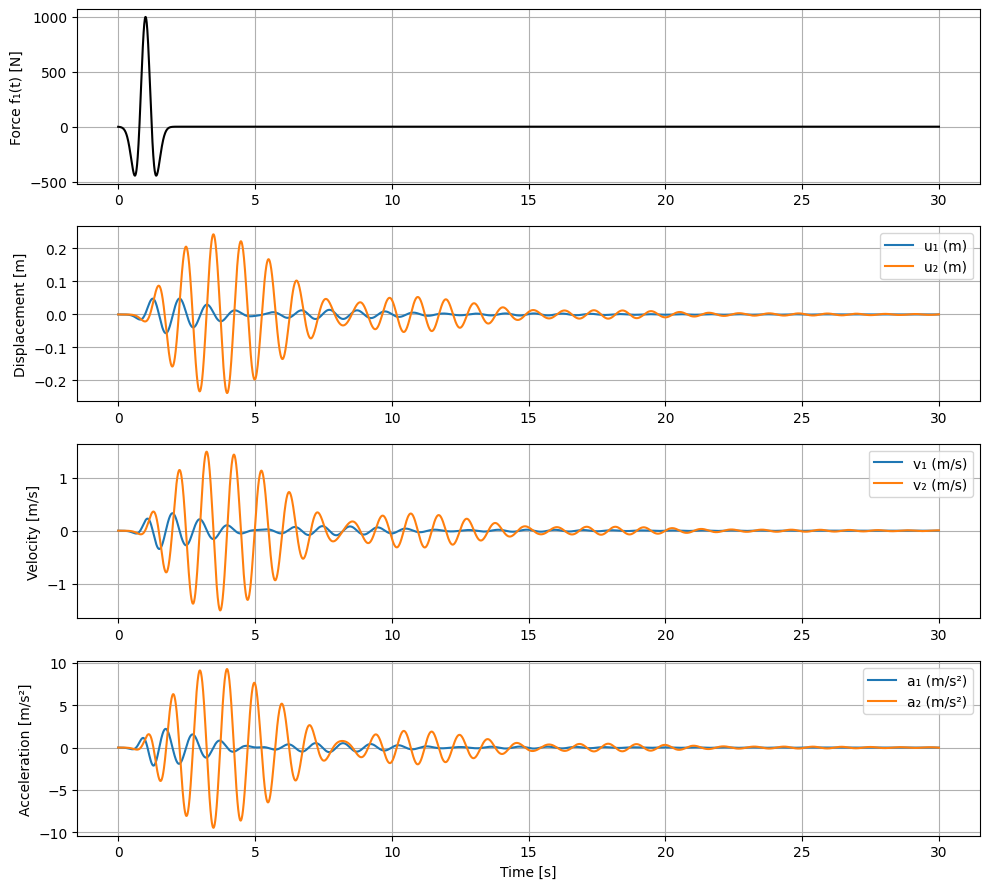

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def f1(t):
    return 1E3*ricker(t - 1.0, f0)   # centered at t = 1

# --- State equations ---
def xdot(t, x):
    x1, x2, x3, x4 = x  # [u1, u1dot, u2, u2dot]
    dx1 = x2
    dx2 = (1.0/m1) * ( f1(t) - (c1+c2)*x2 + c2*x4 - (k1+k2)*x1 + k2*x3 )
    dx3 = x4
    dx4 = (1.0/m2) * ( c2*(x2 - x4) + k2*(x1 - x3) )
    return [dx1, dx2, dx3, dx4]

# --- Initial conditions and time span ---
x0 = [0.0, 0.0, 0.0, 0.0]
t_span = (0.0, 30.0)
t_eval = np.linspace(t_span[0], t_span[1], 4001)

# --- Integrate ---
sol = solve_ivp(xdot, t_span, x0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

t = sol.t
u1, v1, u2, v2 = sol.y

# --- Compute accelerations directly from ODEs ---
a1 = (1.0/m1)*( f1(t) - (c1+c2)*v1 + c2*v2 - (k1+k2)*u1 + k2*u2 )
a2 = (1.0/m2)*( c2*(v1 - v2) + k2*(u1 - u2) )

# --- Plot results ---
plt.figure(figsize=(10,9))

plt.subplot(4,1,1)
plt.plot(t, f1(t), 'k')
plt.ylabel('Force f₁(t) [N]')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, u1, label='u₁ (m)')
plt.plot(t, u2, label='u₂ (m)')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, v1, label='v₁ (m/s)')
plt.plot(t, v2, label='v₂ (m/s)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, a1, label='a₁ (m/s²)')
plt.plot(t, a2, label='a₂ (m/s²)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
